# MODELS 201121

# Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')


import scipy
import statsmodels
from statsmodels.stats.weightstats import *
from scipy.stats import normaltest, chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

from scipy.sparse import csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
# from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score

import gc

# Functions

In [2]:
def GBM_classifier(X,
                   y,
                   model,
                   params):

    print ('\033[1m'+'Gradient boosting machine -','\033[m', model)
    print ()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    X_train.columns = [
    "".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    
    X_test.columns = [
    "".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

    print ('Parametres of model:', params)
    print ()
    X_train = csr_matrix(X_train)
    X_test = csr_matrix(X_test)
    model = model
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    y_train_predict_proba = model.predict_proba(X_train)[:,1]
    y_test_predict_proba = model.predict_proba(X_test)[:,1]

    accuracy =  np.round(accuracy_score(y_test, y_test_predict),4)
    recall = np.round(recall_score(np.array(y_test), y_test_predict, average=None),4)
    precision = np.round(precision_score(y_test, y_test_predict, average=None),4)
    roc_auc = np.round(roc_auc_score(y_test, y_test_predict_proba, average=None),4)

    metrics_df = pd.DataFrame()
    metrics_df['Test'] = np.array([accuracy,recall[0],precision[0],roc_auc])
    metrics_df = metrics_df.rename(index={0: "accuracy", 1: "recall", 2: "precision", 3: "roc_auc"})
    
    accuracy =  np.round(accuracy_score(y_train, y_train_predict),4)
    recall = np.round(recall_score(np.array(y_train), y_train_predict, average=None),4)
    precision = np.round(precision_score(y_train, y_train_predict, average=None),4)
    roc_auc = np.round(roc_auc_score(y_train, y_train_predict_proba, average=None),4)

    metrics_df['Train'] = np.array([accuracy,recall[0],precision[0],roc_auc])
    metrics_df = metrics_df.rename(index={0: "accuracy", 1: "recall", 2: "precision", 3: "roc_auc"})
    
    

    print ('Sample size for TRAIN data:',y_train.shape[0])
    print ('Sample size for TEST data:',y_test.shape[0])
    print ()

    print('Metrics values')
    display(metrics_df.round(4))
    print ()



    list_labels = ['TrueNeg','FalseNeg','TruePos','FalsePos']
    y_data_score = pd.DataFrame()
    y_data_score['y_true'] = np.array(y_test)
    y_data_score['y_predict'] = np.array(y_test_predict)
    data = y_data_score
    columns = []
    for num in range(data.shape[0]):
        for raw in data:

            # conditions to True Negative
            if data['y_true'][num] == 0 and data['y_predict'][num] == 0:
                columns.append([1,0,0,0])
                break
            # conditions to False Negative
            if data['y_true'][num] == 0 and data['y_predict'][num] == 1:
                columns.append([0,1,0,0])
                break
            # conditions to True Positive
            if data['y_true'][num] == 1 and data['y_predict'][num] == 1:
                columns.append([0,0,1,0])
                break
            # conditions to False Positive
            if data['y_true'][num] == 1 and data['y_predict'][num] == 0:
                columns.append([0,0,0,1])
                break

    columns = pd.DataFrame(np.array(columns),columns=list_labels)
    data_confussions = data.join(columns)

    table_confusion = pd.DataFrame()
    table_confusion['Test'] = data_confussions.drop(columns=['y_true','y_predict']).sum().astype(int)

    matrix_confusion = np.zeros((2,2))
    helping_data = data_confussions.drop(columns=['y_true','y_predict']).sum()
    matrix_confusion[0][0] = helping_data[0]
    matrix_confusion[0][1] = helping_data[1]
    matrix_confusion[1][1] = helping_data[2]
    matrix_confusion[1][0] = helping_data[3]
    matrix_confusion_df = pd.DataFrame(matrix_confusion,columns=['0_test','1_test'])
        
    y_data_score = pd.DataFrame()
    y_data_score['y_true'] = np.array(y_train)
    y_data_score['y_predict'] = np.array(y_train_predict)
    data = y_data_score
    columns = []
    for num in range(data.shape[0]):
        for raw in data:

            # conditions to True Negative
            if data['y_true'][num] == 0 and data['y_predict'][num] == 0:
                columns.append([1,0,0,0])
                break
            # conditions to False Negative
            if data['y_true'][num] == 0 and data['y_predict'][num] == 1:
                columns.append([0,1,0,0])
                break
            # conditions to True Positive
            if data['y_true'][num] == 1 and data['y_predict'][num] == 1:
                columns.append([0,0,1,0])
                break
            # conditions to False Positive
            if data['y_true'][num] == 1 and data['y_predict'][num] == 0:
                columns.append([0,0,0,1])
                break

    columns = pd.DataFrame(np.array(columns),columns=list_labels)
    data_confussions = data.join(columns)

    table_confusion['Train'] = data_confussions.drop(columns=['y_true','y_predict']).sum().astype(int)

    matrix_confusion = np.zeros((2,2))
    helping_data = data_confussions.drop(columns=['y_true','y_predict']).sum()
    matrix_confusion[0][0] = helping_data[0]
    matrix_confusion[0][1] = helping_data[1]
    matrix_confusion[1][1] = helping_data[2]
    matrix_confusion[1][0] = helping_data[3]
    matrix_confusion_df['*****'] = np.array(('*****','*****'))
    matrix_confusion = matrix_confusion_df.join(
        pd.DataFrame(matrix_confusion,columns=['0_train','1_train']))

    
    print ('Table confussions')
    display(table_confusion)
    print ()
    
    print ('Matrix confussions')
    display(matrix_confusion)
    print ()



    print ()
    
    return metrics_df, data_confussions, table_confusion, matrix_confusion, model

In [3]:
def GBM_classifier_into_kaggle(X_train,X_test,y_train,model,params):

    print ('\033[1m'+'Gradient boosting machine -','\033[m', model)
    print ()
    

    X_train.columns = [
    "".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    
    X_test.columns = [
    "".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

    print ('Parametres of model:', params)
    print ()
    X_train = csr_matrix(X_train)
    X_test = csr_matrix(X_test)
    model = model
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_train_predict_proba = model.predict_proba(X_train)[:,1]
    y_test_predict = model.predict_proba(X_test)[:,1]
    

    accuracy =  np.round(accuracy_score(y_train, y_train_predict),4)
    recall = np.round(recall_score(np.array(y_train), y_train_predict, average=None),4)
    precision = np.round(precision_score(y_train, y_train_predict, average=None),4)
    roc_auc = np.round(roc_auc_score(y_train, y_train_predict_proba, average=None),4)

    metrics_df = pd.DataFrame()
    metrics_df['Train'] = np.array([accuracy,recall[0],precision[0],roc_auc])
    metrics_df = metrics_df.rename(index={0: "accuracy", 1: "recall", 2: "precision", 3: "roc_auc"})
        
    print ('Sample size for TRAIN data:',y_train.shape[0])
    print ()

    print('Metrics values')
    display(metrics_df.round(4))
    print ()



    list_labels = ['TrueNeg','FalseNeg','TruePos','FalsePos']
        
    y_data_score = pd.DataFrame()
    y_data_score['y_true'] = np.array(y_train)
    y_data_score['y_predict'] = np.array(y_train_predict)
    data = y_data_score
    columns = []
    for num in range(data.shape[0]):
        for raw in data:

            # conditions to True Negative
            if data['y_true'][num] == 0 and data['y_predict'][num] == 0:
                columns.append([1,0,0,0])
                break
            # conditions to False Negative
            if data['y_true'][num] == 0 and data['y_predict'][num] == 1:
                columns.append([0,1,0,0])
                break
            # conditions to True Positive
            if data['y_true'][num] == 1 and data['y_predict'][num] == 1:
                columns.append([0,0,1,0])
                break
            # conditions to False Positive
            if data['y_true'][num] == 1 and data['y_predict'][num] == 0:
                columns.append([0,0,0,1])
                break

    columns = pd.DataFrame(np.array(columns),columns=list_labels)
    data_confussions = data.join(columns)

    table_confusion = pd.DataFrame()
    table_confusion['Train'] = data_confussions.drop(columns=['y_true','y_predict']).sum().astype(int)

    matrix_confusion_df = pd.DataFrame()
    matrix_confusion = np.zeros((2,2))
    helping_data = data_confussions.drop(columns=['y_true','y_predict']).sum()
    matrix_confusion[0][0] = helping_data[0]
    matrix_confusion[0][1] = helping_data[1]
    matrix_confusion[1][1] = helping_data[2]
    matrix_confusion[1][0] = helping_data[3]
    matrix_confusion_df['*****'] = np.array(('*****','*****'))
    matrix_confusion = matrix_confusion_df.join(
        pd.DataFrame(matrix_confusion,columns=['0_train','1_train']))

    
    print ('Table confussions')
    display(table_confusion)
    print ()
    
    print ('Matrix confussions')
    display(matrix_confusion)
    print ()
    
    return metrics_df, data_confussions, table_confusion, matrix_confusion, y_test_predict, model

In [4]:
def gain_df(features,gain):
    gain_df = pd.DataFrame()
    gain_df['Features'] = features
    gain_df['Gain'] = gain
    return gain_df.sort_values('Gain', ascending=False)

In [5]:
def gain_hist(df,size,start,stop):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('Gain', ascending=False)['Features'][start:stop])
    y = (df.sort_values('Gain', ascending=False)['Gain'][start:stop])
    plt.bar(x,y)
    plt.xlabel('Features')
    plt.ylabel('Gain')
    plt.xticks(rotation=90)
    plt.show()

In [6]:
def anomalies_off(data,
                 anomalies_columns,
                 anomalies_values,
                 anomalies_signs):
    # create dataframe with anomalies
    data_anomalies_off = pd.DataFrame()
    for i in range(len(anomalies_columns)):
        if anomalies_signs[i] == 'more':
            #     create column
            data_anomalies_off[anomalies_columns[i]] = data[anomalies_columns[i]]
            #     change anomaly value in column to anomaly label - 'anomaly'
            data_anomalies_off[anomalies_columns[i]][
                data_anomalies_off[anomalies_columns[i]] >= anomalies_values[i]] = 'anomaly'
        else:
            #     create column
            data_anomalies_off[anomalies_columns[i]] = data[anomalies_columns[i]]
            #     change anomaly value in column to anomaly label - 'anomaly'
            data_anomalies_off[anomalies_columns[i]][
                data_anomalies_off[anomalies_columns[i]] <= anomalies_values[i]] = 'anomaly'

    #  create dataframe with label no data before delete anomaly values
    label_no_data_anomalies_off = pd.DataFrame()
    for i in anomalies_columns:
        label_no_data_anomalies_off[i] = data[i]
        label_no_data_anomalies_off[i][label_no_data_anomalies_off[i].isnull()] = 'no data'
        label_no_data_anomalies_off[i][label_no_data_anomalies_off[i] != 'no data'] = 0
        label_no_data_anomalies_off[i][label_no_data_anomalies_off[i] == 'no data'] = 1
        label_no_data_anomalies_off[i] = label_no_data_anomalies_off[i].astype(int)
        
    # rename columns in dataframe
    for i in list(label_no_data_anomalies_off.columns):
        label_no_data_anomalies_off['label_no_data_anomalies_off_%s' %i] = label_no_data_anomalies_off[i]
    label_no_data_anomalies_off = label_no_data_anomalies_off.drop(anomalies_columns,axis=1) 
    
    # create dataframe with label anomalies
    label_anomalies_off = data_anomalies_off.copy()
    for i in list(label_anomalies_off.columns):
        label_anomalies_off[i][label_anomalies_off[i] != 'anomaly'] = 0
        label_anomalies_off[i][label_anomalies_off[i] == 'anomaly'] = 1
        label_anomalies_off[i] = label_anomalies_off[i].astype(int)


    for i in list(data_anomalies_off.columns):
        data_anomalies_off[i][data_anomalies_off[i] == 'anomaly'] = None
        data_anomalies_off[i] = data_anomalies_off[i].astype(float)

    # rename columns in dataframe with label anomalies
    for i in list(label_anomalies_off.columns):
        label_anomalies_off['label_anomalies_off_%s' %i] = label_anomalies_off[i]
    label_anomalies_off = label_anomalies_off.drop(anomalies_columns,axis=1)    


    # rename columns in dataframe with label anomalies
    for i in list(data_anomalies_off.columns):
        data_anomalies_off['anomalies_off_%s' %i] = data_anomalies_off[i]
    data_anomalies_off = data_anomalies_off.drop(anomalies_columns,axis=1)  

    X = data.drop(anomalies_columns,axis=1)
    X = X.join(data_anomalies_off)
    X = X.join(label_no_data_anomalies_off)
    X = X.join(label_anomalies_off)
    
    return X, data[anomalies_columns], label_anomalies_off, data_anomalies_off

In [7]:
def cross_validation(X,y,model,fold):

    metrics_df = pd.DataFrame()
    list_labels = ['TrueNeg','FalseNeg','TruePos','FalsePos']
    table_confusion = pd.DataFrame()
    matrix_confusion = pd.DataFrame()

    n_fold = 1
    for train_index, test_index in fold.split(X, y):
        X_train, y_train = np.array(X)[train_index], np.array(y)[train_index]
        X_test, y_test = np.array(X)[test_index], np.array(y)[test_index]

        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        roc_auc = np.round(roc_auc_score(y_test, y_test_predict, average=None),4)
        metrics_df['Fold №%s' % n_fold] = [roc_auc]

        y_data_score = pd.DataFrame()
        y_data_score['y_true'] = np.array(y_test)
        y_data_score['y_predict'] = np.array(y_test_predict)
        data = y_data_score
        columns = []
        for num in range(data.shape[0]):
            for raw in data:

                # conditions to True Negative
                if data['y_true'][num] == 0 and data['y_predict'][num] == 0:
                    columns.append([1,0,0,0])
                    break
                # conditions to False Negative
                if data['y_true'][num] == 0 and data['y_predict'][num] == 1:
                    columns.append([0,1,0,0])
                    break
                # conditions to True Positive
                if data['y_true'][num] == 1 and data['y_predict'][num] == 1:
                    columns.append([0,0,1,0])
                    break
                # conditions to False Positive
                if data['y_true'][num] == 1 and data['y_predict'][num] == 0:
                    columns.append([0,0,0,1])
                    break

        columns = pd.DataFrame(np.array(columns),columns=list_labels)
        data_confussions = data.join(columns)
        table_confusion['Fold №%s' % n_fold] = data_confussions.drop(columns=['y_true','y_predict']).sum().astype(int)

        matrix_confusion_temp = np.zeros((2,2))
        helping_data = data_confussions.drop(columns=['y_true','y_predict']).sum()
        matrix_confusion_temp[0][0] = helping_data[0]
        matrix_confusion_temp[0][1] = helping_data[1]
        matrix_confusion_temp[1][1] = helping_data[2]
        matrix_confusion_temp[1][0] = helping_data[3]
        matrix_confusion['0 fold №%s' % n_fold] = matrix_confusion_temp[:,0]
        matrix_confusion['1 fold №%s' % n_fold] = matrix_confusion_temp[:,1]
        matrix_confusion['*%s' % n_fold] = np.array(('*****','*****'))


        n_fold += 1

    metrics_df = metrics_df.rename(index={0: "roc_auc"})
    
    return metrics_df, table_confusion, matrix_confusion

In [8]:
def compare_columns(data_train, data_test):
    print ('The columns that are',
           '\033[1m' +  'IN THE DATA 1' + '\033[0m', 
           'and the columns that are', 
           '\033[1m' +  'NOT IN THE DATA 2' + '\033[0m')
    print (set(data_train.columns) - set(data_test.columns))
    print ('****************************************************************************************')

    print ('The columns that are',
           '\033[1m' +  'NOT IN THE DATA 1' + '\033[0m', 
           'and the columns that are', 
           '\033[1m' +  'IN THE DATA 2' + '\033[0m')
    print (set(data_test.columns) - set(data_train.columns))
    print ('****************************************************************************************')

In [9]:
def rename_agg_columns(id_client,data,rename):
    columns = [id_client]
    for lev_0 in data.columns.levels[0]:
        if lev_0 != id_client:
            for lev_1 in data.columns.levels[1][:-1]:
                columns.append(rename % (lev_0, lev_1))
    data.columns = columns
    return data

# Application train

In [10]:
'''
Download and preprocessing data from application form
'''


# download data
app_train = pd.read_csv('application_train.csv')
app_train = app_train.rename(columns={"TARGET": "target"})

# copy data
data_app = app_train.copy()

# drop anomaly values
anomalies_columns = ['AMT_REQ_CREDIT_BUREAU_QRT',
                     'DEF_60_CNT_SOCIAL_CIRCLE',
                     'OBS_60_CNT_SOCIAL_CIRCLE',
                     'DEF_30_CNT_SOCIAL_CIRCLE',
                     'OBS_30_CNT_SOCIAL_CIRCLE',
                     'AMT_INCOME_TOTAL',
                     'DAYS_EMPLOYED']
anomalies_values = [19,24,344,34,348,4500000,0]
anomalies_signs = ['more','more','more','more','more','more','more']

X_app, data_anomalies_on, label_anomalies_off, data_anomalies_off = anomalies_off(
                 data_app,
                 anomalies_columns,
                 anomalies_values,
                 anomalies_signs)

# create some logical features
X_app['ratio_INCOME/ANNUITY'] = X_app['anomalies_off_AMT_INCOME_TOTAL']/X_app['AMT_ANNUITY']
X_app['diff_INCOME&ANNUITY'] = X_app['anomalies_off_AMT_INCOME_TOTAL'] - X_app['AMT_ANNUITY']
X_app['ratio_FINANCE_CHILDREN'] = X_app['anomalies_off_AMT_INCOME_TOTAL']/(X_app['CNT_CHILDREN']+1)
X_app['diff_FINCHIL&ANNUITY'] = X_app['ratio_FINANCE_CHILDREN'] - X_app['AMT_ANNUITY']

X_app['ratio_GOOD_PRICE/CREDIT'] = X_app['AMT_GOODS_PRICE']/X_app['AMT_CREDIT']

X_app['ratio_WORKING_SUCCESS_1'] = X_app['anomalies_off_AMT_INCOME_TOTAL']/(X_app['anomalies_off_DAYS_EMPLOYED']/-365)
X_app['ratio_WORKING_SUCCESS_4'] = X_app['anomalies_off_AMT_INCOME_TOTAL']/(X_app['DAYS_BIRTH']/-365)
X_app['ratio_CREDIT/ANNUITY'] = X_app['AMT_CREDIT']/X_app['AMT_ANNUITY']


X_app['ratio_CREDIT/INCOME'] = X_app['AMT_CREDIT']/X_app['anomalies_off_AMT_INCOME_TOTAL']
X_app['ratio_WORKING_SUCCESS_2'] = X_app['anomalies_off_AMT_INCOME_TOTAL']/(X_app['DAYS_ID_PUBLISH']/-365)
X_app['ratio_WORKING_SUCCESS_3'] = (X_app['DAYS_ID_PUBLISH']/-365)/(X_app['anomalies_off_DAYS_EMPLOYED']/-365)

# drop target feature from learning sample
X_app = X_app.drop(columns=['target'])

# create vector of answers
y = data_app['target']

# binarization categorical data
X_app_num = X_app.drop(columns=list(X_app.select_dtypes(include='object').columns))
X_app_object = pd.get_dummies(X_app.select_dtypes(include='object'))
X_app = X_app_object.join(X_app_num)

X = X_app.copy()

# Bureau data

In [11]:
'''
Download and preprocessing train data from Credit Bureau
'''

# download data from credit bureau
bureau = pd.read_csv('bureau.csv')

# create feature with quantity of loans per client
bureau_data = pd.DataFrame()
bureau_data[['SK_ID_CURR', 'bureau_NUMBERS_OF_LOANS']] = bureau.select_dtypes(
    include='int').groupby(
    ['SK_ID_CURR']).count().reset_index()[['SK_ID_CURR', 'SK_ID_BUREAU']]

# create features with use float and int type of data
new_features = pd.DataFrame()
new_features = bureau.drop(['SK_ID_BUREAU'], axis=1).select_dtypes(
    include=['int', 'float']).groupby(
    'SK_ID_CURR').agg(['mean', 'max', 'min', 'sum']).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='bureau_%s_%s')
bureau_data = bureau_data.merge(new_features, on='SK_ID_CURR',how='left')

# create features with use object data
new_features = bureau.select_dtypes(include='object')
new_features = pd.get_dummies(new_features)
new_features['SK_ID_CURR'] = bureau['SK_ID_CURR']
new_features = new_features.groupby(['SK_ID_CURR']).agg([sum]).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='bureau_%s_%s')
bureau_data = bureau_data.merge(new_features, on='SK_ID_CURR',how='left')

# create some logical features (calculate mounth annuity per active loans)
temp_df = bureau[bureau['CREDIT_ACTIVE']=='Active'][
    bureau['DAYS_CREDIT']<0][
    bureau['DAYS_CREDIT_ENDDATE']>0][
    bureau['AMT_CREDIT_SUM']>0][[
    'SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT','DAYS_CREDIT_ENDDATE','AMT_CREDIT_SUM']]

temp_df['calculation_CREDIT_PERIOD'] = -temp_df['DAYS_CREDIT']+temp_df['DAYS_CREDIT_ENDDATE']
temp_df['calculation_ANNUITY_day'] = temp_df['AMT_CREDIT_SUM']/temp_df['calculation_CREDIT_PERIOD']
temp_df['calculation_ANNUITY_month'] = 30.4*temp_df['calculation_ANNUITY_day']
temp_df['calculation_RESIDUAL_CREDIT'] = temp_df['calculation_ANNUITY_day']*temp_df['DAYS_CREDIT_ENDDATE']
temp_df = temp_df.drop(['DAYS_CREDIT','DAYS_CREDIT_ENDDATE'],axis=1)

new_features = temp_df.drop(['SK_ID_BUREAU'], axis=1).groupby(
    'SK_ID_CURR').agg([sum]).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='bureau_%s_%s')
bureau_data = bureau_data.merge(new_features, on='SK_ID_CURR',how='left')

# create some logical features in bureau data (sum of active credits per each main type credit)
columns = ['SK_ID_CURR', 'Consumer credit','Credit card', 'Mortgage', 'Car loan', 'Microloan']
df = pd.DataFrame(bureau['SK_ID_CURR'])
for column in columns[1:]:
    temp_df = bureau[
    bureau['CREDIT_ACTIVE']=='Active'][
    bureau['CREDIT_TYPE']==column][['SK_ID_CURR','AMT_CREDIT_SUM']]
    df = df.merge(temp_df, on = 'SK_ID_CURR', how = 'left')
df.columns = columns

new_features = df.groupby(
    'SK_ID_CURR').agg([sum]).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='bureau_%s_%s')
bureau_data = bureau_data.merge(new_features, on='SK_ID_CURR',how='left')

# create some logical features in bureau data (sum negative credit limit)
temp_df = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_LIMIT']][
    bureau['AMT_CREDIT_SUM_LIMIT']<0]
new_features = temp_df.groupby('SK_ID_CURR').agg([sum]).reset_index()
new_features.columns = ['SK_ID_CURR','bureau_AMT_CREDIT_SUM_LIMIT_negative']
bureau_data = bureau_data.merge(new_features, on='SK_ID_CURR',how='left')

# create some logical features in bureau data (ratio: credit sum to credit limit)
temp_df = bureau[['SK_ID_CURR','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']][
    bureau['AMT_CREDIT_SUM_LIMIT']>0][
    bureau['CREDIT_ACTIVE']=='Active'][
    bureau['CREDIT_TYPE']=='Credit card']
new_features = temp_df.groupby('SK_ID_CURR').agg([sum]).reset_index()
new_features['ratio_bureau_CREDIT_SUM/CREDIT_LIMIT'] = \
    new_features['AMT_CREDIT_SUM']/new_features['AMT_CREDIT_SUM_LIMIT']
new_features = new_features.drop(['AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT'],axis=1)
new_features.columns = ['SK_ID_CURR','ratio_bureau_CREDIT_SUM/CREDIT_LIMIT']

bureau_data = bureau_data.merge(new_features, on='SK_ID_CURR',how='left')

# Previous applications data

In [12]:
'''
Download and preprocessing data from previous applications in HCB per client
'''

# download data
prev_app = pd.read_csv('previous_application.csv')

In [13]:
# create feature with numbers of loans per client
prev_app_data = pd.DataFrame()
prev_app_data[['SK_ID_CURR', 'prev_app_NUMBERS_OF_LOANS']] = prev_app.groupby(
    ['SK_ID_CURR']).count().reset_index()[['SK_ID_CURR', 'SK_ID_PREV']]

# drop anomaly values
prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# create new features using type of data float
list_float_agg = {'AMT_ANNUITY':['sum','min','max','mean','std'],
              'AMT_APPLICATION':['sum','min','max','mean','std'],
              'AMT_CREDIT':['sum','min','max','mean'],
              'AMT_DOWN_PAYMENT':['sum','min','max','mean'],
              'AMT_GOODS_PRICE':['sum','min','max','mean'],
              'CNT_PAYMENT':['sum','min','max','mean'],
              'RATE_DOWN_PAYMENT':['min','max','mean'],
              'RATE_INTEREST_PRIMARY':['max','mean'],
              'RATE_INTEREST_PRIVILEGED':['min','max','mean'],
              'NFLAG_INSURED_ON_APPROVAL':['sum'], 
              'DAYS_DECISION':['min','max','mean'],
              'DAYS_FIRST_DRAWING':['min','max','mean'],
              'DAYS_FIRST_DUE':['min','max','mean'],
              'DAYS_LAST_DUE_1ST_VERSION':['min','max','mean'],
              'DAYS_LAST_DUE':['min','max','mean'],
              'DAYS_TERMINATION':['min','max','mean'],
              'HOUR_APPR_PROCESS_START':['min','max','mean'],
              'SELLERPLACE_AREA':['min','max','mean']}
new_features = prev_app.groupby('SK_ID_CURR').agg(list_float_agg).reset_index()
new_features.columns = pd.Index(['prev_app_' + e[0] + "_" + e[1] for e in new_features.columns.tolist()])
new_features = new_features.rename(columns={"prev_app_SK_ID_CURR_": "SK_ID_CURR"})
prev_app_data = prev_app_data.merge(new_features, on='SK_ID_CURR',how='left')

# create new features using type of data object
temp_df = prev_app.select_dtypes(include='object')
temp_df = pd.get_dummies(temp_df)
temp_df['SK_ID_CURR'] = prev_app['SK_ID_CURR']
new_features = temp_df.groupby(['SK_ID_CURR']).agg([sum]).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='prev_app_%s_%s')
prev_app_data = prev_app_data.merge(new_features, on='SK_ID_CURR',how='left')

# create some logical features from previous application forms
# indicate the loan amount ('prev_app_AMT_CREDIT') for each category of the selected features
new_features = pd.DataFrame(prev_app[['SK_ID_CURR','SK_ID_PREV']])
columns = ['SK_ID_CURR', 
            'NAME_CONTRACT_TYPE',
            'NAME_CONTRACT_STATUS',
            'NAME_PORTFOLIO']
for column in columns[1:]:
    for i in prev_app[column].unique():
        features_temp = pd.DataFrame(prev_app[['SK_ID_PREV','AMT_CREDIT']][
        prev_app[column]==i])
        features_temp.columns = ['SK_ID_PREV','prev_app_AMT_CREDIT_%s_%s' % (column,i)]
        new_features = new_features.merge(features_temp, on='SK_ID_PREV',how='left')
new_features = new_features.drop('prev_app_AMT_CREDIT_NAME_CONTRACT_TYPE_XNA',axis=1)
new_features = new_features.drop('SK_ID_PREV',axis=1).groupby('SK_ID_CURR').agg(
    ['sum']).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='%s_%s')
prev_app_data = prev_app_data.merge(new_features, on='SK_ID_CURR',how='left')


# create some logical features from previous application forms
# indicate the approved loan amount ('prev_app_AMT_CREDIT' & 'Approved') for each category of the selected features
new_features = pd.DataFrame(prev_app[['SK_ID_CURR','SK_ID_PREV']])
columns = ['SK_ID_CURR', 
            'NAME_CONTRACT_TYPE',
            'NAME_PORTFOLIO']
analyse_column = 'NAME_CONTRACT_STATUS'
analyse_category = 'Approved'
for column in columns[1:]:
    for i in prev_app[column][prev_app[analyse_column]==analyse_category].unique():
        features_temp = pd.DataFrame(
            prev_app[['SK_ID_PREV','AMT_CREDIT']][
            prev_app[analyse_column]==analyse_category][
            prev_app[column]==i])
        features_temp.columns = ['SK_ID_PREV','prev_app_Approved_AMT_CREDIT_%s_%s' % (column,i)]
        new_features = new_features.merge(features_temp, on='SK_ID_PREV',how='left')
new_features = new_features.drop('SK_ID_PREV',axis=1).groupby('SK_ID_CURR').agg(
    ['sum']).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='%s_%s')
prev_app_data = prev_app_data.merge(new_features, on='SK_ID_CURR',how='left')


# create some logical features from previous application forms
# count some ratios using only the approved loans
new_features = pd.DataFrame()
list_features = ['SK_ID_CURR','AMT_CREDIT','AMT_ANNUITY','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE']
new_features = prev_app[prev_app['NAME_CONTRACT_STATUS']=='Approved'][list_features]
new_features = new_features.groupby('SK_ID_CURR').agg(['sum']).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='%s_%s')

new_features['ratio_prev_app_CREDIT_sum/ANNUITY_sum'] =\
    new_features['AMT_CREDIT_sum']/new_features['AMT_ANNUITY_sum']
new_features['ratio_prev_app_GOODS_PRICE_sum/CREDIT_sum'] =\
    new_features['AMT_GOODS_PRICE_sum']/new_features['AMT_CREDIT_sum']
new_features['ratio_prev_app_DOWN_PAYMENT_sum/CREDIT_sum'] =\
    new_features['AMT_DOWN_PAYMENT_sum']/new_features['AMT_CREDIT_sum']
prev_app_data = prev_app_data.merge(new_features, on='SK_ID_CURR',how='left')

# Previous credit card balance data

In [14]:
'''
Download and preprocessing data from previous credit card balance in HCB per client
'''

# download data
credit_card = pd.read_csv('credit_card_balance.csv')

In [15]:
# DATA: PREVIOUS CREDIT CARDS PER CLIENT

# create feature with numbers of loans per client
credit_card_data = pd.DataFrame()
credit_card_data[['SK_ID_CURR', 'prev_app_NUMBERS_OF_LOANS']] = credit_card.groupby(
    ['SK_ID_CURR']).count().reset_index()[['SK_ID_CURR', 'SK_ID_PREV']]

# create new features using type of data object
temp_df = credit_card.select_dtypes(include='object')
temp_df = pd.get_dummies(temp_df)
temp_df['SK_ID_CURR'] = credit_card['SK_ID_CURR']
new_features = temp_df.groupby(['SK_ID_CURR']).agg([sum]).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='credit_card_%s_%s')
credit_card_data = credit_card_data.merge(new_features, on='SK_ID_CURR',how='left')

# create some logical features from credit balance data
# count some ratios and differences
credit_card['ratio_LIMIT_USE'] = credit_card['AMT_BALANCE']/credit_card['AMT_CREDIT_LIMIT_ACTUAL']
credit_card['diff_PAYMENTS'] = credit_card['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card['AMT_INST_MIN_REGULARITY']

# create new features using type of data float
list_float_agg = {'MONTHS_BALANCE':['min'],
              'AMT_CREDIT_LIMIT_ACTUAL':['sum','min','max','mean','std'],
              'CNT_DRAWINGS_CURRENT':['sum','max','mean','std'],
              'SK_DPD':['sum','max','mean','std'],
              'SK_DPD_DEF':['sum','mean','std'],
              'AMT_BALANCE':['sum','min','max','mean','std'],
              'AMT_DRAWINGS_ATM_CURRENT':['sum','max','mean','std'],
              'AMT_DRAWINGS_CURRENT':['sum','min','max','mean','std'],
              'AMT_DRAWINGS_OTHER_CURRENT':['sum','max','mean'],
              'AMT_DRAWINGS_POS_CURRENT':['sum','min','max','mean','std'], 
              'AMT_INST_MIN_REGULARITY':['sum','min','max','mean','std'],
              'AMT_PAYMENT_CURRENT':['sum','min','max','mean','std'],
              'AMT_PAYMENT_TOTAL_CURRENT':['sum','min','max','mean','std'],
              'AMT_RECEIVABLE_PRINCIPAL':['sum','min','max','mean','std'],
              'AMT_RECEIVABLE_PRINCIPAL':['sum','min','max','mean','std'],
              'AMT_TOTAL_RECEIVABLE':['sum','min','max','mean','std'],
              'CNT_DRAWINGS_ATM_CURRENT':['sum','max','mean'],
              'CNT_DRAWINGS_OTHER_CURRENT':['sum','mean'],
              'CNT_DRAWINGS_POS_CURRENT':['sum','max','mean'],
              'CNT_INSTALMENT_MATURE_CUM':['sum','min','max','mean','std'],
              'ratio_LIMIT_USE':['min','max','mean','std'],
              'diff_PAYMENTS':['sum','min','max','mean','std']}
new_features = credit_card.groupby('SK_ID_CURR').agg(list_float_agg).reset_index()
new_features.columns = pd.Index(['credit_card_' + e[0] + "_" + e[1] for e in new_features.columns.tolist()])
new_features = new_features.rename(columns={"credit_card_SK_ID_CURR_": "SK_ID_CURR"})

credit_card_data = credit_card_data.merge(new_features, on='SK_ID_CURR',how='left')

# Previous POS-CASH balance data

In [16]:
'''
Download and preprocessing data from previous POS-CASH balance in HCB per client
'''

# download data
cash_balance = pd.read_csv('POS_CASH_balance.csv')

In [17]:
# DATA: POS-CASH-BALANCE PER CLIENT

# create feature with numbers of previous loan per client
cash_balance_data = pd.DataFrame()
cash_balance_data[['SK_ID_CURR', 'cash_balance_NUMBERS']] = cash_balance.groupby(
    'SK_ID_CURR').count().reset_index()[['SK_ID_CURR', 'SK_ID_PREV']]

# create new features using type of data object
temp_df = cash_balance.select_dtypes(include='object')
temp_df = pd.get_dummies(temp_df)
temp_df['SK_ID_CURR'] = cash_balance['SK_ID_CURR']
new_features = temp_df.groupby(['SK_ID_CURR']).agg([sum]).reset_index()
new_features = rename_agg_columns(id_client='SK_ID_CURR',data=new_features,rename='cash_balance_%s_%s')
cash_balance_data = cash_balance_data.merge(new_features, on='SK_ID_CURR',how='left')

# create new features using type of data float
list_float_agg = {'MONTHS_BALANCE':['min'],
              'SK_DPD':['sum','max','mean','std'],
              'SK_DPD_DEF':['sum','max','mean','std'],
              'CNT_INSTALMENT':['sum','min','max','mean','std'],
              'CNT_INSTALMENT_FUTURE':['sum','min','max','mean','std']}
new_features = cash_balance.groupby('SK_ID_CURR').agg(list_float_agg).reset_index()
new_features.columns = pd.Index(['cash_balance_' + e[0] + "_" + e[1] for e in new_features.columns.tolist()])
new_features = new_features.rename(columns={"cash_balance_SK_ID_CURR_": "SK_ID_CURR"})

cash_balance_data = cash_balance_data.merge(new_features, on='SK_ID_CURR',how='left')

# drop duplicates in columns
# credit_card_data = credit_card_data.T.drop_duplicates().T

# Previous installments payments data

In [18]:
'''
Download and preprocessing data from previous installments payments in HCB per client
'''

# download data
installments_payments = pd.read_csv('installments_payments.csv')

In [19]:
# DATA: INSTALLMENTS PAYMENTS PER CLIENT

# create feature with numbers of previous loan per client
installments_payments_data = pd.DataFrame()
installments_payments_data[['SK_ID_CURR', 'install_pay_NUMBERS']] = installments_payments.groupby(
    'SK_ID_CURR').count().reset_index()[['SK_ID_CURR', 'SK_ID_PREV']]

# create new features using type of data float
list_float_agg = {'NUM_INSTALMENT_VERSION':['sum','max','mean','std'],
              'NUM_INSTALMENT_NUMBER':['sum','max','mean','std'],
              'DAYS_INSTALMENT':['sum','min','max','mean','std'],
              'DAYS_ENTRY_PAYMENT':['sum','min','max','mean','std'],
              'AMT_INSTALMENT':['sum','min','max','mean','std'],
              'AMT_PAYMENT':['sum','min','max','mean','std']}
new_features = installments_payments.groupby('SK_ID_CURR').agg(list_float_agg).reset_index()
new_features.columns = pd.Index(['install_pay_' + e[0] + "_" + e[1] for e in new_features.columns.tolist()])
new_features = new_features.rename(columns={"install_pay_SK_ID_CURR_": "SK_ID_CURR"})

installments_payments_data = installments_payments_data.merge(new_features, on='SK_ID_CURR',how='left')

# Union data: create data

In [20]:
list_data = ['bureau_data',
             'prev_app_data',
             'credit_card_data',
             'cash_balance_data',
             'installments_payments_data']

In [21]:
X_union = X.merge(bureau_data, on='SK_ID_CURR', how='left')
X_union = X_union.merge(prev_app_data, on='SK_ID_CURR', how='left')
X_union = X_union.merge(credit_card_data, on='SK_ID_CURR', how='left')
X_union = X_union.merge(cash_balance_data, on='SK_ID_CURR', how='left')
X_union = X_union.merge(installments_payments_data, on='SK_ID_CURR', how='left')

# Union data: create some logical features

In [22]:
# create new features with bureau data and applications data
X_union['ratio_ALL_CREDIT'] = \
    X_union['AMT_CREDIT'] + X_union['bureau_AMT_CREDIT_SUM_sum_y']

X_union['ratio_percent_of_bureau_CREDIT'] = \
    X_union['AMT_CREDIT'] / X_union['bureau_AMT_CREDIT_SUM_sum_y']

X_union['ratio_ALL_ANNUITY'] = \
    X_union['AMT_ANNUITY'] + X_union['bureau_calculation_ANNUITY_month_sum']

X_union['ratio_ALL_FUTURE_PAYMENTS'] = \
    X_union['AMT_CREDIT'] + X_union['bureau_calculation_RESIDUAL_CREDIT_sum']

X_union['ratio_ALL_ANNUITY/AMT_INCOME_TOTAL'] = \
    X_union['ratio_ALL_ANNUITY'] / X_union['anomalies_off_AMT_INCOME_TOTAL']

X_union['ratio_ALL_FUTURE_PAYMENTS/AMT_INCOME_TOTAL'] = \
    X_union['ratio_ALL_FUTURE_PAYMENTS'] / X_union['anomalies_off_AMT_INCOME_TOTAL']

X_union['ratio_SAFETY_1'] = \
    X_union['ratio_ALL_ANNUITY/AMT_INCOME_TOTAL'] * X_union['ratio_ALL_FUTURE_PAYMENTS/AMT_INCOME_TOTAL']

# create some logical features using data from previous and current aplication forms
X_union['ratio_CREDIT_cur/prev'] = \
    X_union['AMT_CREDIT']/X_union['AMT_CREDIT_sum']

X_union['ratio_GOODS_PRICE_cur/prev'] = \
    X_union['AMT_GOODS_PRICE']/X_union['AMT_GOODS_PRICE_sum']

X_union['ratio_ratio_GOODS_PRICE/CREDIT_cur/prev'] = \
    X_union['ratio_GOOD_PRICE/CREDIT']/X_union['ratio_prev_app_GOODS_PRICE_sum/CREDIT_sum']

In [23]:
X_union.shape

(307511, 746)

# Union data: drope some columns which have zero gain

In [24]:
X_union = X_union.drop('SK_ID_CURR',axis=1)

list_zero_gain = ['cash_balance_NAME_CONTRACT_STATUS_Demand_sum',
 'NAME_TYPE_SUITE_Group of people',
 'HOUSETYPE_MODE_block of flats',
 'ORGANIZATION_TYPE_Trade: type 1',
 'cash_balance_NAME_CONTRACT_STATUS_Canceled_sum',
 'label_anomalies_off_DEF_30_CNT_SOCIAL_CIRCLE',
 'cash_balance_NAME_CONTRACT_STATUS_Amortized debt_sum',
 'label_anomalies_off_OBS_30_CNT_SOCIAL_CIRCLE',
 'label_anomalies_off_AMT_INCOME_TOTAL',
 'label_anomalies_off_DAYS_EMPLOYED',
 'ORGANIZATION_TYPE_Trade: type 5',
 'ORGANIZATION_TYPE_Trade: type 4',
 'label_anomalies_off_OBS_60_CNT_SOCIAL_CIRCLE',
 'CODE_GENDER_XNA',
 'ORGANIZATION_TYPE_Telecom',
 'ORGANIZATION_TYPE_Industry: type 8',
 'NAME_FAMILY_STATUS_Unknown',
 'label_anomalies_off_DEF_60_CNT_SOCIAL_CIRCLE',
 'NAME_FAMILY_STATUS_Widow',
 'ORGANIZATION_TYPE_Religion',
 'ORGANIZATION_TYPE_Realtor',
 'WALLSMATERIAL_MODE_Wooden',
 'bureau_CREDIT_DAY_OVERDUE_min',
 'ORGANIZATION_TYPE_Postal',
 'ORGANIZATION_TYPE_Mobile',
 'ORGANIZATION_TYPE_Legal Services',
 'ORGANIZATION_TYPE_Insurance',
 'bureau_CNT_CREDIT_PROLONG_min',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_INCOME_TYPE_Pensioner',
 'label_anomalies_off_AMT_REQ_CREDIT_BUREAU_QRT',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_10',
 'NAME_EDUCATION_TYPE_Academic degree',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_7',
 'ORGANIZATION_TYPE_Transport: type 1',
 'NAME_INCOME_TYPE_Unemployed',
 'FLAG_DOCUMENT_4',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Student',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_21',
 'cash_balance_NAME_CONTRACT_STATUS_XNA_sum',
 'label_no_data_anomalies_off_DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'label_no_data_anomalies_off_DAYS_EMPLOYED',
 'label_no_data_anomalies_off_AMT_INCOME_TOTAL',
 'label_no_data_anomalies_off_OBS_30_CNT_SOCIAL_CIRCLE',
 'label_no_data_anomalies_off_OBS_60_CNT_SOCIAL_CIRCLE',
 'NAME_INCOME_TYPE_Businessman',
 'label_no_data_anomalies_off_DEF_60_CNT_SOCIAL_CIRCLE',
 'label_no_data_anomalies_off_AMT_REQ_CREDIT_BUREAU_QRT',
 'ORGANIZATION_TYPE_Trade: type 6',
 'FLAG_CONT_MOBILE',
 'LIVE_REGION_NOT_WORK_REGION',
 'ORGANIZATION_TYPE_Industry: type 6',
 'ORGANIZATION_TYPE_XNA',
 'prev_app_NAME_SELLER_INDUSTRY_Tourism_sum',
 'ORGANIZATION_TYPE_Industry: type 5',
 'ORGANIZATION_TYPE_Industry: type 2',
 'prev_app_NAME_TYPE_SUITE_Group of people_sum',
 'prev_app_CODE_REJECT_REASON_XNA_sum',
 'prev_app_CODE_REJECT_REASON_SYSTEM_sum',
 'credit_card_NAME_CONTRACT_STATUS_Approved_sum',
 'prev_app_NAME_PAYMENT_TYPE_Non-cash from your account_sum',
 'credit_card_NAME_CONTRACT_STATUS_Demand_sum',
 'credit_card_NAME_CONTRACT_STATUS_Refused_sum',
 'credit_card_NAME_CONTRACT_STATUS_Sent proposal_sum',
 'prev_app_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum',
 'OCCUPATION_TYPE_IT staff',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Payments on other loans_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Journey_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Hobby_sum',
 'prev_app_NAME_TYPE_SUITE_Other_A_sum',
 'prev_app_NAME_GOODS_CATEGORY_Additional Service_sum',
 'prev_app_Approved_AMT_CREDIT_NAME_PORTFOLIO_XNA_sum',
 'prev_app_NAME_GOODS_CATEGORY_Office Appliances_sum',
 'prev_app_CHANNEL_TYPE_Car dealer_sum',
 'prev_app_NAME_PORTFOLIO_Cars_sum',
 'OCCUPATION_TYPE_HR staff',
 'prev_app_NAME_GOODS_CATEGORY_Weapon_sum',
 'prev_app_NAME_GOODS_CATEGORY_Tourism_sum',
 'prev_app_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_sum',
 'prev_app_NAME_GOODS_CATEGORY_Other_sum',
 'prev_app_NAME_GOODS_CATEGORY_Insurance_sum',
 'prev_app_Approved_AMT_CREDIT_NAME_PORTFOLIO_Cars_sum',
 'prev_app_NAME_GOODS_CATEGORY_House Construction_sum',
 'prev_app_AMT_CREDIT_NAME_PORTFOLIO_Cars_sum',
 'prev_app_NAME_GOODS_CATEGORY_Gardening_sum',
 'prev_app_NAME_GOODS_CATEGORY_Fitness_sum',
 'prev_app_NAME_GOODS_CATEGORY_Education_sum',
 'prev_app_NAME_GOODS_CATEGORY_Direct Sales_sum',
 'prev_app_NAME_GOODS_CATEGORY_Animals_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Furniture_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Buying a used car_sum',
 'prev_app_NAME_SELLER_INDUSTRY_MLM partners_sum',
 'bureau_CREDIT_TYPE_Mobile operator loan_sum',
 'bureau_CREDIT_TYPE_Loan for working capital replenishment_sum',
 'bureau_CREDIT_TYPE_Loan for the purchase of equipment_sum',
 'bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum',
 'bureau_CREDIT_TYPE_Loan for business development_sum',
 'bureau_CREDIT_TYPE_Interbank credit_sum',
 'bureau_CREDIT_TYPE_Cash loan (non-earmarked)_sum',
 'bureau_CREDIT_CURRENCY_currency 4_sum',
 'bureau_CREDIT_TYPE_Unknown type of loan_sum',
 'bureau_CREDIT_CURRENCY_currency 3_sum',
 'bureau_CREDIT_CURRENCY_currency 2_sum',
 'bureau_CREDIT_ACTIVE_Bad debt_sum',
 'ORGANIZATION_TYPE_Industry: type 11',
 'ORGANIZATION_TYPE_Industry: type 12',
 'ORGANIZATION_TYPE_Industry: type 13',
 'bureau_AMT_CREDIT_SUM_OVERDUE_min',
 'bureau_CREDIT_TYPE_Real estate loan_sum',
 'ORGANIZATION_TYPE_Industry: type 10',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum',
 'OCCUPATION_TYPE_Secretaries',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Buying a home_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Business development_sum',
 'prev_app_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum',
 'prev_app_NAME_CONTRACT_TYPE_XNA_sum',
 'OCCUPATION_TYPE_Realty agents',
 'OCCUPATION_TYPE_Security staff',
 'ORGANIZATION_TYPE_Housing',
 'ORGANIZATION_TYPE_Advertising',
 'ORGANIZATION_TYPE_Cleaning',
 'ORGANIZATION_TYPE_Culture',
 'bureau_AMT_CREDIT_SUM_LIMIT_negative',
 'ORGANIZATION_TYPE_Electricity',
 'ORGANIZATION_TYPE_Emergency',
 'ORGANIZATION_TYPE_Hotel',
                 'WALLSMATERIAL_MODE_Block',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'prev_app_NAME_GOODS_CATEGORY_Medicine_sum',
 'EMERGENCYSTATE_MODE_No',
 'bureau_CREDIT_TYPE_Another type of loan_sum',
 'ORGANIZATION_TYPE_Transport: type 4',
                 'prev_app_NAME_CASH_LOAN_PURPOSE_Education_sum',
 'ORGANIZATION_TYPE_Security',
 'prev_app_PRODUCT_COMBINATION_POS others without interest_sum',
                 'OCCUPATION_TYPE_Managers',
 'prev_app_NAME_GOODS_CATEGORY_Auto Accessories_sum',
 'OCCUPATION_TYPE_Sales staff',
 'prev_app_NAME_GOODS_CATEGORY_Homewares_sum',
                 'prev_app_CODE_REJECT_REASON_CLIENT_sum',
 'WEEKDAY_APPR_PROCESS_START_SUNDAY',
 'prev_app_NAME_SELLER_INDUSTRY_Construction_sum']
X_union = X_union.drop(list_zero_gain,axis=1)

In [25]:
X_union.shape

(307511, 584)

# Start model on the union data

In [139]:
%%time

seed = 42
params = {'n_estimators': 5000,
          'objective': 'binary',
          'max_depth': 4,
          'min_child_samples': 20,
          'learning_rate': 0.05, 
          'reg_lambda': 0.75,
          'subsample': 0.75,
          'colsample_bytree': 0.4,
          'min_split_gain': 0.02,
          'min_child_weight': 40,
          'random_state': seed}
model_union = lgb.LGBMClassifier(**params)
metrics, data_conf, table_conf, matrix_conf, model_union = GBM_classifier(X_union,y,model_union,params)

Gradient boosting machine -  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               importance_type='split', learning_rate=0.05, max_depth=4,
               min_child_samples=20, min_child_weight=40, min_split_gain=0.02,
               n_estimators=5000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=42, reg_alpha=0.0, reg_lambda=0.75, silent=True,
               subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

Parametres of model: {'n_estimators': 5000, 'objective': 'binary', 'max_depth': 4, 'min_child_samples': 20, 'learning_rate': 0.05, 'reg_lambda': 0.75, 'subsample': 0.75, 'colsample_bytree': 0.4, 'min_split_gain': 0.02, 'min_child_weight': 40, 'random_state': 42}

Sample size for TRAIN data: 206032
Sample size for TEST data: 101479

Metrics values


,Test,Train
accuracy,0.9196,0.9373
recall,0.9940,0.9990
precision,0.9243,0.9369
roc_auc,0.7828,0.9448



Table confussions


,Test,Train
TrueNeg,92728,189206
FalseNeg,559,193
TruePos,595,3898
FalsePos,7597,12735



Matrix confussions


,0_test,1_test,*****,0_train,1_train
0,92728.0,559.0,*****,189206.0,193.0
1,7597.0,595.0,*****,12735.0,3898.0




CPU times: user 38min 24s, sys: 4.08 s, total: 38min 28s
Wall time: 5min 28s


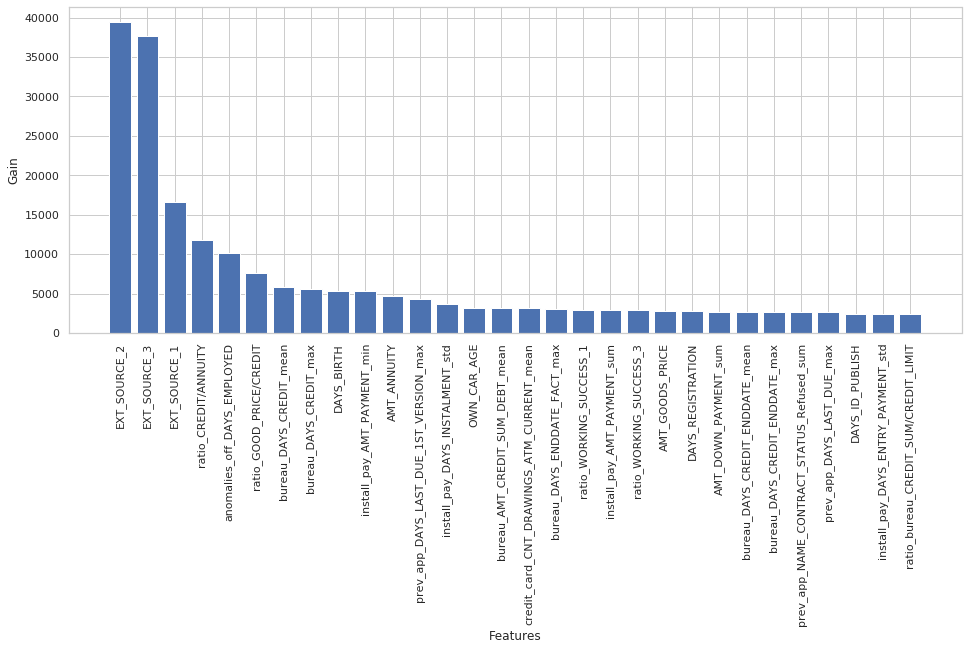

,Features,Gain
109,EXT_SOURCE_2,39385.458221
110,EXT_SOURCE_3,37673.740683
108,EXT_SOURCE_1,16675.439666
180,ratio_CREDIT/ANNUITY,11843.382755
172,anomalies_off_DAYS_EMPLOYED,10206.320174
177,ratio_GOOD_PRICE/CREDIT,7599.741412
185,bureau_DAYS_CREDIT_mean,5884.070512
186,bureau_DAYS_CREDIT_max,5595.891905
92,DAYS_BIRTH,5360.740152
570,install_pay_AMT_PAYMENT_min,5310.906592


In [145]:
features = X_union.columns
gain = model_union.booster_.feature_importance(importance_type='gain')
size = (16,6)
start = 0
stop = 30

df = gain_df(features,gain)
gain_hist(df,size,start,stop)
df[start:stop]

In [141]:
# list(df[start:stop]['Features'])

In [142]:
# df[df['Features']=='ratio_ratio_GOODS_PRICE/CREDIT_cur/prev']

# Application data for Kaggle

In [26]:
# download data
app_test = pd.read_csv('application_test.csv')

# copy data
data_test = app_test.copy()

# drop anomaly values
anomalies_columns = ['AMT_REQ_CREDIT_BUREAU_QRT',
                     'DEF_60_CNT_SOCIAL_CIRCLE',
                     'OBS_60_CNT_SOCIAL_CIRCLE',
                     'DEF_30_CNT_SOCIAL_CIRCLE',
                     'OBS_30_CNT_SOCIAL_CIRCLE',
                     'AMT_INCOME_TOTAL',
                     'DAYS_EMPLOYED']
anomalies_values = [19,24,344,34,348,4500000,0]
anomalies_signs = ['more','more','more','more','more','more','more']

X_app_test, data_anomalies_on, label_anomalies_off, data_anomalies_off = anomalies_off(
                 data_test,
                 anomalies_columns,
                 anomalies_values,
                 anomalies_signs)

# create some logical features
X_app_test['ratio_INCOME/ANNUITY'] = X_app_test['anomalies_off_AMT_INCOME_TOTAL']/X_app_test['AMT_ANNUITY']
X_app_test['diff_INCOME&ANNUITY'] = X_app_test['anomalies_off_AMT_INCOME_TOTAL'] - X_app_test['AMT_ANNUITY']
X_app_test['ratio_FINANCE_CHILDREN'] = X_app_test['anomalies_off_AMT_INCOME_TOTAL']/(X_app_test['CNT_CHILDREN']+1)
X_app_test['diff_FINCHIL&ANNUITY'] = X_app_test['ratio_FINANCE_CHILDREN'] - X_app_test['AMT_ANNUITY']
X_app_test['ratio_GOOD_PRICE/CREDIT'] = X_app_test['AMT_GOODS_PRICE']/X_app_test['AMT_CREDIT']
X_app_test['ratio_WORKING_SUCCESS_1'] = \
    X_app_test['anomalies_off_AMT_INCOME_TOTAL']/(X_app_test['anomalies_off_DAYS_EMPLOYED']/-365)
X_app_test['ratio_WORKING_SUCCESS_4'] = \
    X_app_test['anomalies_off_AMT_INCOME_TOTAL']/(X_app_test['DAYS_BIRTH']/-365)
X_app_test['ratio_CREDIT/ANNUITY'] = X_app_test['AMT_CREDIT']/X_app_test['AMT_ANNUITY']
X_app_test['ratio_CREDIT/INCOME'] = X_app_test['AMT_CREDIT']/X_app_test['anomalies_off_AMT_INCOME_TOTAL']
X_app_test['ratio_WORKING_SUCCESS_2'] = \
    X_app_test['anomalies_off_AMT_INCOME_TOTAL']/(X_app_test['DAYS_ID_PUBLISH']/-365)
X_app_test['ratio_WORKING_SUCCESS_3'] = \
    (X_app_test['DAYS_ID_PUBLISH']/-365)/(X_app_test['anomalies_off_DAYS_EMPLOYED']/-365)

# binarization categorical data
X_app_test_num = X_app_test.drop(columns=list(X_app_test.select_dtypes(include='object').columns))
X_app_test_object = pd.get_dummies(X_app_test.select_dtypes(include='object'))
X_app_test = X_app_test_object.join(X_app_test_num)

# Union data for Kaggle

In [27]:
X_train = X_union

In [28]:
list_data = ['bureau_data',
             'prev_app_data',
             'credit_card_data',
             'cash_balance_data',
             'installments_payments_data']

In [29]:
X_test = X_app_test
X_test = X_test.merge(bureau_data, on = 'SK_ID_CURR', how = 'left')
X_test = X_test.merge(prev_app_data, on = 'SK_ID_CURR', how = 'left')
X_test = X_test.merge(credit_card_data, on = 'SK_ID_CURR', how = 'left')
X_test = X_test.merge(cash_balance_data, on = 'SK_ID_CURR', how = 'left')
X_test = X_test.merge(installments_payments_data, on = 'SK_ID_CURR', how = 'left')

# Create some logical features in Union data for Kaggle

In [30]:
# create new features with bureau data and applications data
X_test['ratio_ALL_CREDIT'] = \
    X_test['AMT_CREDIT'] + X_test['bureau_AMT_CREDIT_SUM_sum_y']

X_test['ratio_percent_of_bureau_CREDIT'] = \
    X_test['AMT_CREDIT'] / X_test['bureau_AMT_CREDIT_SUM_sum_y']

X_test['ratio_ALL_ANNUITY'] = \
    X_test['AMT_ANNUITY'] + X_test['bureau_calculation_ANNUITY_month_sum']

X_test['ratio_ALL_FUTURE_PAYMENTS'] = \
    X_test['AMT_CREDIT'] + X_test['bureau_calculation_RESIDUAL_CREDIT_sum']

X_test['ratio_ALL_ANNUITY/AMT_INCOME_TOTAL'] = \
    X_test['ratio_ALL_ANNUITY'] / X_test['anomalies_off_AMT_INCOME_TOTAL']

X_test['ratio_ALL_FUTURE_PAYMENTS/AMT_INCOME_TOTAL'] = \
    X_test['ratio_ALL_FUTURE_PAYMENTS'] / X_test['anomalies_off_AMT_INCOME_TOTAL']

X_test['ratio_SAFETY_1'] = \
    X_test['ratio_ALL_ANNUITY/AMT_INCOME_TOTAL'] * X_test['ratio_ALL_FUTURE_PAYMENTS/AMT_INCOME_TOTAL']

# create some logical features using data from previous and current aplication forms
X_test['ratio_CREDIT_cur/prev'] = \
    X_test['AMT_CREDIT']/X_test['AMT_CREDIT_sum']

X_test['ratio_GOODS_PRICE_cur/prev'] = \
    X_test['AMT_GOODS_PRICE']/X_test['AMT_GOODS_PRICE_sum']

X_test['ratio_ratio_GOODS_PRICE/CREDIT_cur/prev'] = \
    X_test['ratio_GOOD_PRICE/CREDIT']/X_test['ratio_prev_app_GOODS_PRICE_sum/CREDIT_sum']

In [31]:
X_test.shape

(48744, 743)

In [32]:
X_train.columns = [
    "".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = [
    "".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)

In [33]:
X_test.shape

(48744, 584)

In [34]:
X_union.shape

(307511, 584)

In [226]:
# list_zero_gain = ['ORGANIZATION_TYPE_University',
#  'ORGANIZATION_TYPE_Transport__type_2',
#  'prev_app_CODE_REJECT_REASON_VERIF_sum',
#  'prev_app_NAME_CLIENT_TYPE_XNA_sum',
#  'HOUSETYPE_MODE_terraced_house',
#  'ORGANIZATION_TYPE_Agriculture',
#  'prev_app_NAME_GOODS_CATEGORY_Medical_Supplies_sum',
#  'ORGANIZATION_TYPE_Services',
#  'prev_app_NAME_CASH_LOAN_PURPOSE_Everyday_expenses_sum',
#  'EMERGENCYSTATE_MODE_Yes',
#  'NAME_HOUSING_TYPE_Co_op_apartment',
#  'prev_app_RATE_INTEREST_PRIVILEGED_min',
#  'FLAG_DOCUMENT_5',
#  'cash_balance_NAME_CONTRACT_STATUS_Approved_sum',
#  'ORGANIZATION_TYPE_Industry__type_7',
#  'ORGANIZATION_TYPE_Industry__type_4',
#  'ORGANIZATION_TYPE_Industry__type_1',
#                  'WALLSMATERIAL_MODE_Monolithic',
#  'WALLSMATERIAL_MODE_Mixed',
#  'prev_app_NAME_CASH_LOAN_PURPOSE_Car_repairs_sum',
#  'prev_app_RATE_INTEREST_PRIVILEGED_mean',
#  'prev_app_NAME_GOODS_CATEGORY_Vehicles_sum',
#  'OCCUPATION_TYPE_Cleaning_staff',
#  'OCCUPATION_TYPE_Cooking_staff']

# X_train = X_train.drop(list_zero_gain,axis=1)
# X_test = X_test.drop(list_zero_gain,axis=1)

In [35]:
X_train.shape

(307511, 584)

# Start model for Kaggle

In [36]:
%%time

seed = 50

params_lgb_4 = {'n_estimators': 10000,
          'objective': 'binary',
          'max_depth': 4,
          'min_child_samples': 20,
          'learning_rate': 0.008, 
          'reg_lambda': 0.075,
          'subsample': 0.75,
          'colsample_bytree': 0.4,
          'min_split_gain': 0.025,
          'min_child_weight': 40,                
          'random_state': seed}

model_1 = lgb.LGBMClassifier(**params_lgb_4)
metrics,data_conf,table_conf,matrix_conf,y_test_predict,model_1 = GBM_classifier_into_kaggle(
    X_train,
    X_test,
    y,
    model_1,
    params_lgb_4)

Gradient boosting machine -  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               importance_type='split', learning_rate=0.008, max_depth=4,
               min_child_samples=20, min_child_weight=40, min_split_gain=0.025,
               n_estimators=10000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.075, silent=True,
               subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

Parametres of model: {'n_estimators': 10000, 'objective': 'binary', 'max_depth': 4, 'min_child_samples': 20, 'learning_rate': 0.008, 'reg_lambda': 0.075, 'subsample': 0.75, 'colsample_bytree': 0.4, 'min_split_gain': 0.025, 'min_child_weight': 40, 'random_state': 50}

Sample size for TRAIN data: 307511

Metrics values


,Train
accuracy,0.9244
recall,0.9977
precision,0.9258
roc_auc,0.8548



Table confussions


,Train
TrueNeg,282037
FalseNeg,649
TruePos,2224
FalsePos,22601



Matrix confussions


,*****,0_train,1_train
0,*****,282037.0,649.0
1,*****,22601.0,2224.0



CPU times: user 2h 1min 22s, sys: 19.3 s, total: 2h 1min 41s
Wall time: 17min 55s


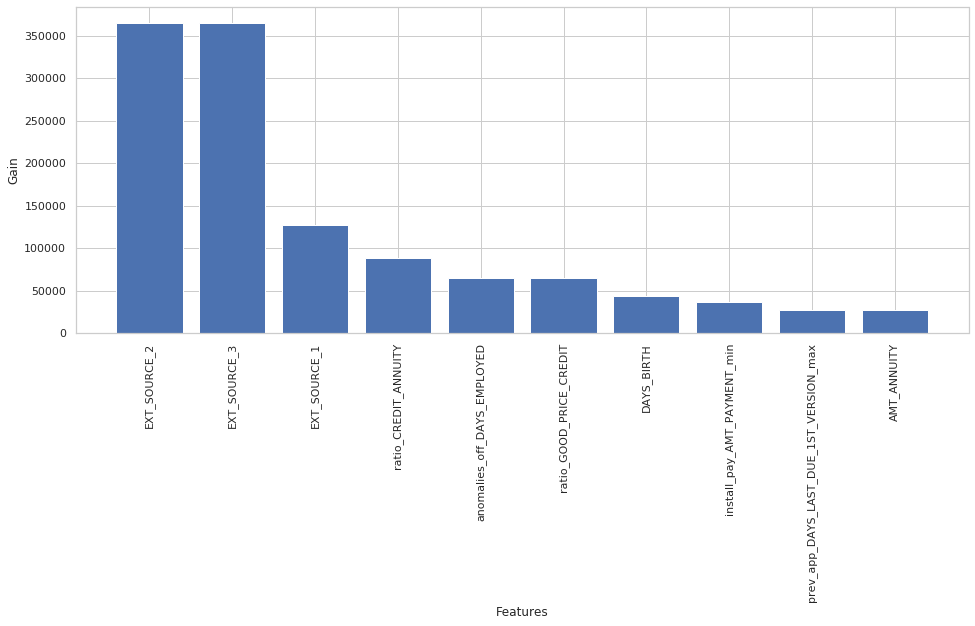

,Features,Gain
109,EXT_SOURCE_2,365572.043180
110,EXT_SOURCE_3,365435.411779
108,EXT_SOURCE_1,127219.177001
180,ratio_CREDIT_ANNUITY,89195.923447
172,anomalies_off_DAYS_EMPLOYED,65536.644935
177,ratio_GOOD_PRICE_CREDIT,65454.164754
92,DAYS_BIRTH,43653.827914
570,install_pay_AMT_PAYMENT_min,37216.729151
296,prev_app_DAYS_LAST_DUE_1ST_VERSION_max,27770.639356
89,AMT_ANNUITY,27406.895656


In [37]:
features = list(X_train.columns)
gain = model_1.booster_.feature_importance(importance_type='gain')
size = (16,6)
start = 0
stop = 10

df = gain_df(features,gain)
gain_hist(df,size,start,stop)
df[start:stop]

In [206]:
# list(df[start:stop]['Features'])

In [142]:
# df[df['Features']=='ratio_ratio_GOODS_PRICE/CREDIT_cur/prev']

In [234]:
submition = app_test[['SK_ID_CURR']]
submition['TARGET'] = y_test_predict
submition.to_csv('LGBM_m1_10000.csv', index = False)

### SCORE into KAGGLE - 0.79454

# PLACE IN LEADERBOARD

In [39]:
leaderboard = pd.read_excel('publicleaderboard.xlsx')

In [40]:
places = leaderboard.groupby('id_teamlead').agg('max').reset_index()
places = places.sort_values('score',ascending=False).reset_index()

# The current place

In [41]:
my_score = 0.79454
df = places[places['score']>=my_score]
df = df.drop('index',axis=1)
my_place = places[places['score']>=my_score].shape[0]
participants = places.shape[0]

print ('My score:',my_score)
print ('The best score:',df['score'].iloc[0])
print ('The differences:',round(my_score - df['score'].iloc[0],6))
print ()
print ('There are','\033[1m',participants,'\033[m','participants')
print ('My place is','\033[1m',my_place,'\033[m','from all participants')
print ('My part is end of','\033[1m',int(100*my_place/participants),'%','\033[m',
       'the best works from participants')

display(df)

My score: 0.79454
The best score: 0.81724
The differences: -0.0227

There are  7173  participants
My place is  2940  from all participants
My part is end of  40 %  the best works from participants


,id_teamlead,score
0,1708353,0.81724
1,1729033,0.81515
2,1710843,0.81391
3,1717122,0.81326
4,1736411,0.81322
...,...,...
2935,1705687,0.79457
2936,1754011,0.79457
2937,1815949,0.79456
2938,1873029,0.79455


# 10 days before

In [44]:
my_score = 0.78566
df = places[places['score']>=my_score]
df = df.drop('index',axis=1)
my_place = places[places['score']>=my_score].shape[0]
participants = places.shape[0]

print ('My score:',my_score)
print ('The best score:',df['score'].iloc[0])
print ('The differences:',round(my_score - df['score'].iloc[0],6))
print ()
print ('There are','\033[1m',participants,'\033[m','participants')
print ('My place is','\033[1m',my_place,'\033[m','from all participants')
print ('My part is end of','\033[1m',int(100*my_place/participants),'%','\033[m',
       'the best works from participants')

My score: 0.78566
The best score: 0.81724
The differences: -0.03158

There are  7173  participants
My place is  3708  from all participants
My part is end of  51 %  the best works from participants


# last in past part (some months ago)

In [45]:
my_score = 0.77218
df = places[places['score']>=my_score]
df = df.drop('index',axis=1)
my_place = places[places['score']>=my_score].shape[0]
participants = places.shape[0]

print ('My score:',my_score)
print ('The best score:',df['score'].iloc[0])
print ('The differences:',round(my_score - df['score'].iloc[0],6))
print ()
print ('There are','\033[1m',participants,'\033[m','participants')
print ('My place is','\033[1m',my_place,'\033[m','from all participants')
print ('My part is end of','\033[1m',int(100*my_place/participants),'%','\033[m',
       'the best works from participants')

My score: 0.77218
The best score: 0.81724
The differences: -0.04506

There are  7173  participants
My place is  4459  from all participants
My part is end of  62 %  the best works from participants
